## Import data

In [1]:
import os
import sys

sys.path.insert(1, os.path.realpath(os.path.pardir)) # you do not need this

import torch
from torch.utils.data import DataLoader
import torchmetrics
import matplotlib.pyplot as plt
import numpy as np

## Example of binary classification;
#### Simulate some waveforms for 2 channels

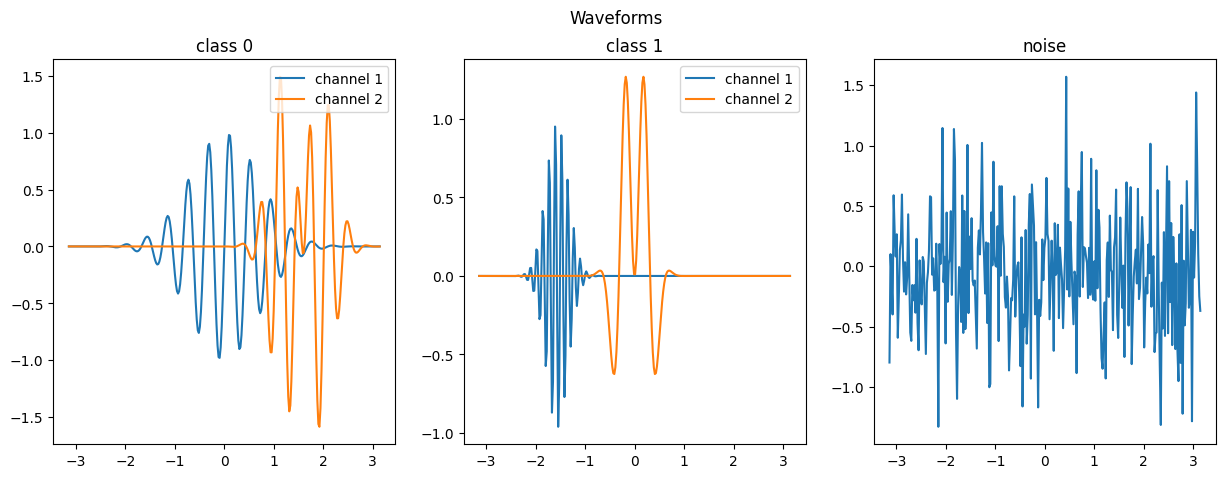

In [2]:
n_times = 300
n_channels = 2
n_samples = 1000

t = np.linspace(-np.pi, np.pi, n_times)

wave1_ch1 = np.sin(15*t)*np.exp(-t**2)
wave1_ch2 = 15*(np.sin(.5*t - np.pi/4)*np.sin(16*t - np.pi/4))*np.exp(-(t - np.pi/2)**2/.25)
wave2_ch1 = np.sin(50*t)*np.exp(-(t + np.pi/2)**2/.1)
wave2_ch2 = 10*t*np.sin(10*t)*np.exp(-(t)**2/.1)
noise = np.random.normal(0, .5, n_times)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Waveforms')
ax1.plot(t, wave1_ch1, t, wave1_ch2)
ax1.set_title('class 0')
ax1.legend(['channel 1', 'channel 2'], loc='upper right')
ax2.plot(t, wave2_ch1, t, wave2_ch2)
ax2.legend(['channel 1', 'channel 2'], loc='upper right')
ax2.set_title('class 1')
ax3.plot(t, noise)
ax3.set_title('noise')
plt.show()

## Create dataset with generated waveforms and additive gaussian noise

In [3]:
X = np.random.normal(0, .5, (n_samples, n_channels, n_times))
X[:n_samples//2, 0, :] += np.expand_dims(wave1_ch1, 0)
X[:n_samples//2, 1, :] += np.expand_dims(wave1_ch2, 0)
X[n_samples//2:, 0, :] += np.expand_dims(wave2_ch1, 0)
X[n_samples//2:, 1, :] += np.expand_dims(wave2_ch2, 0)

labels = np.concatenate([np.zeros(n_samples//2), np.ones(n_samples//2)], 0)

## Plot one sample for each class

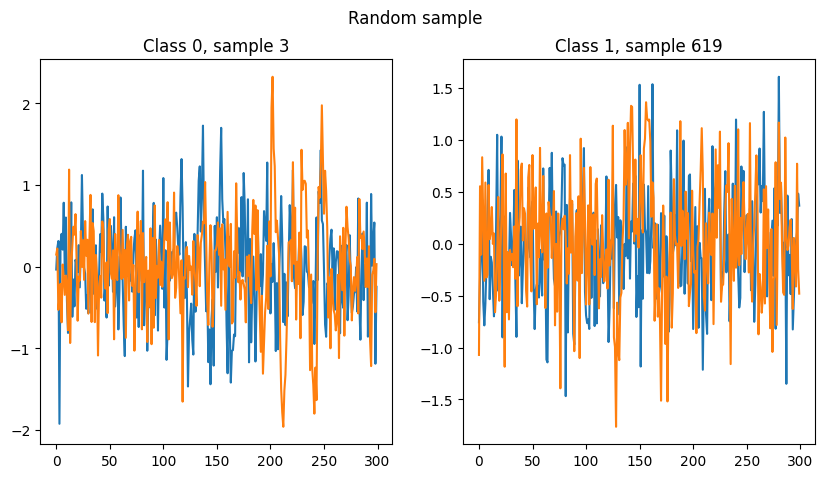

In [4]:
i = np.random.randint(n_samples//2)
j = n_samples//2 + np.random.randint(n_samples//2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Random sample')
ax1.plot(X[i].T)
ax1.set_title(f'Class 0, sample {i}')
ax2.plot(X[j].T)
ax2.set_title(f'Class 1, sample {j}')
plt.show()

## Plot averaged data

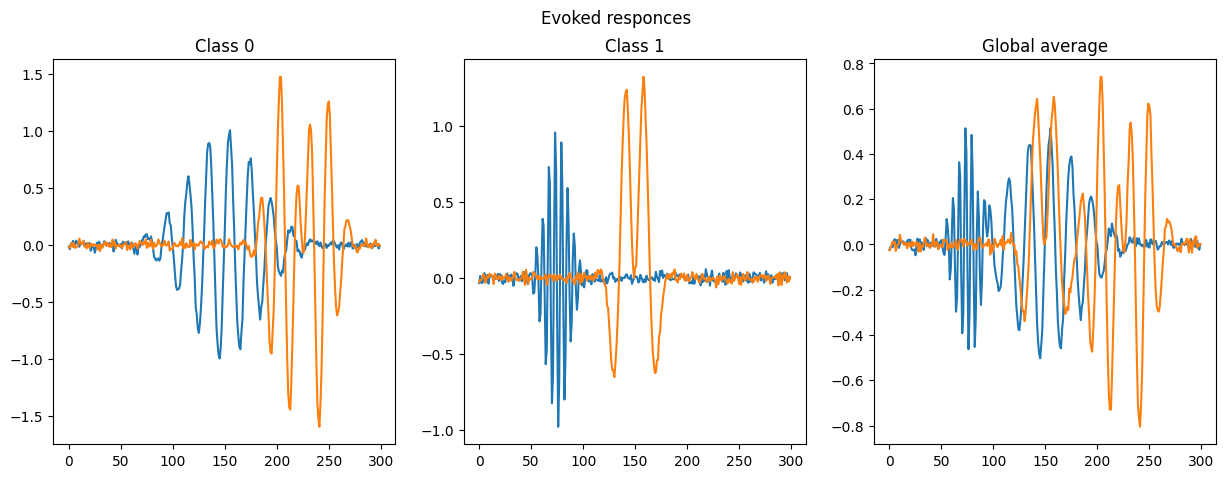

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Evoked responces')
ax1.plot(X[:n_samples//2].mean(0).T)
ax1.set_title('Class 0')
ax2.plot(X[n_samples//2:].mean(0).T)
ax2.set_title('Class 1')
ax3.plot(X.mean(0).T)
ax3.set_title('Global average')
plt.show()

## Labels indicate which class every sample belongs to

In [6]:
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## But to train neural network it is better to make one-hot decoding of these labels

In [7]:
from deepmeg.preprocessing.transforms import one_hot_decoder, one_hot_encoder

Y = one_hot_encoder(labels)
Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

## It is also possible to go back from decoded labels

In [8]:
np.all(labels == one_hot_decoder(Y))

True

## Creating dataset with samplens and corresponding one-hot decoded labels

In [9]:
from deepmeg.data.datasets import EpochsDataset
from deepmeg.preprocessing.transforms import zscore

dataset = EpochsDataset(
    (X, Y), # matrix of samples and matrix of labels (targets)
    transform=zscore, # when we load a new sample, we always apply this transformation to it
    savepath='../datasets/wavelets' # samples are saved in 'savepath' directory
)
dataset.save('../data/wavelets.pt') # save dataset itself

## We can also load an existing dataset

In [10]:
dataset = EpochsDataset.load('../data/wavelets.pt')

## Splitting dataset into train and test sets

In [11]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

## Plot one randomly taken sample

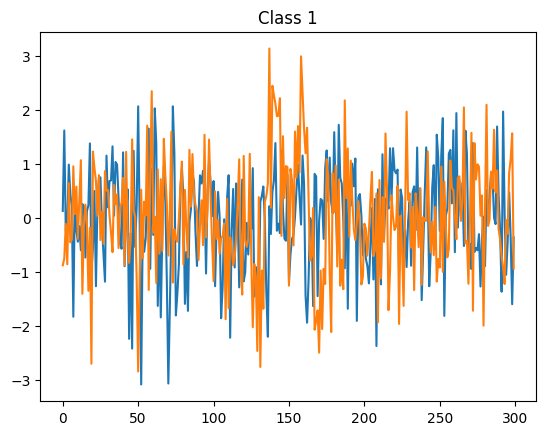

In [12]:
sample, label = next(iter(DataLoader(train, 1)))

plt.plot(sample[0].T)
plt.title(f'Class {one_hot_decoder(label)[0]}')
plt.show()

## Create a model

In [24]:
from deepmeg.models.interpretable import LFCNN


model = LFCNN(
    n_channels=n_channels, # ~ number of channels
    n_latent=8, # ~ number of latent factors
    n_times=n_times, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=2 # ~ number of output classes (number of events in epochs) = Y.shape[-1] = 2
)

## We can see a design of the model

In [14]:
print(model)

LFCNN(
  (unmixing_layer): Conv1d(2, 8, kernel_size=(1,), stride=(1,))
  (temp_conv): Conv1d(8, 8, kernel_size=(50,), stride=(1,), padding=same, groups=8)
  (fc_layer): Linear(in_features=240, out_features=2, bias=True)
)


## And to check what kind of parameters it is able to learn

In [15]:
for layer_name in model.state_dict().keys():
    print(f'\t*   {layer_name}')

	*   unmixing_layer.weight
	*   unmixing_layer.bias
	*   temp_conv.weight
	*   temp_conv.bias
	*   fc_layer.weight
	*   fc_layer.bias


## We can modify learning process at different steps (e.g. start of epoch, end of epoch, start of batch, end of batch, etc) by callable objects called Callbacks

In [16]:
from deepmeg.training.callbacks import PrintingCallback, EarlyStopping, L2Reg

## Compile the model
#### For each model we must define an optimizer and a loss function
#### Also, optionally, we can define evaluation metrics and callbacks

In [25]:
optimizer = torch.optim.Adam
# it is also possible to define an optimizer as follows:
# optimizer = torch.optim.Adam(model.parameters())

loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

## Training the model

In [26]:
history = model.fit(train, n_epochs=15, batch_size=200, val_batch_size=60)

Epoch 0:  loss_train:  0.7168   |    binary_accuracy_train:  0.5514   |    loss_val:  0.6880   |    binary_accuracy_val:  0.6629
Epoch 1:  loss_train:  0.6799   |    binary_accuracy_train:  0.7326   |    loss_val:  0.6539   |    binary_accuracy_val:  0.8127
Epoch 2:  loss_train:  0.6454   |    binary_accuracy_train:  0.8878   |    loss_val:  0.6210   |    binary_accuracy_val:  0.9188
Epoch 3:  loss_train:  0.6116   |    binary_accuracy_train:  0.9532   |    loss_val:  0.5877   |    binary_accuracy_val:  0.9630
Epoch 4:  loss_train:  0.5771   |    binary_accuracy_train:  0.9759   |    loss_val:  0.5529   |    binary_accuracy_val:  0.9850
Epoch 5:  loss_train:  0.5410   |    binary_accuracy_train:  0.9922   |    loss_val:  0.5161   |    binary_accuracy_val:  0.9919
Epoch 6:  loss_train:  0.5027   |    binary_accuracy_train:  0.9956   |    loss_val:  0.4771   |    binary_accuracy_val:  0.9919
Epoch 7:  loss_train:  0.4623   |    binary_accuracy_train:  1.0000   |    loss_val:  0.4361   | 

## History of the training process is a dictionary, containing epochwise changes of each metric

In [27]:
print(history)

{'loss_train': array([0.71683002, 0.67985972, 0.64542069, 0.61163765, 0.57713203,
       0.54097023, 0.50269316, 0.46229793, 0.42020146, 0.37717644,
       0.33425309, 0.29258797, 0.25331802, 0.21742763, 0.18564238]), 'binary_accuracy_train': array([0.55137889, 0.7326319 , 0.88782974, 0.95321343, 0.97587532,
       0.99223622, 0.99556955, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'loss_val': array([0.68798401, 0.65389802, 0.62095733, 0.58766677, 0.5529333 ,
       0.51613615, 0.47711704, 0.43614907, 0.39388353, 0.35126426,
       0.30940711, 0.26945751, 0.23245335, 0.19921616, 0.17026991]), 'binary_accuracy_val': array([0.66287263, 0.81273713, 0.91876696, 0.96300813, 0.98502709,
       0.99186993, 0.99186993, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])}


## We can visualize the training history

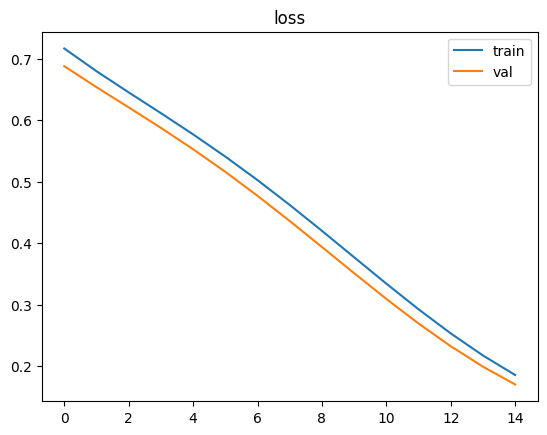

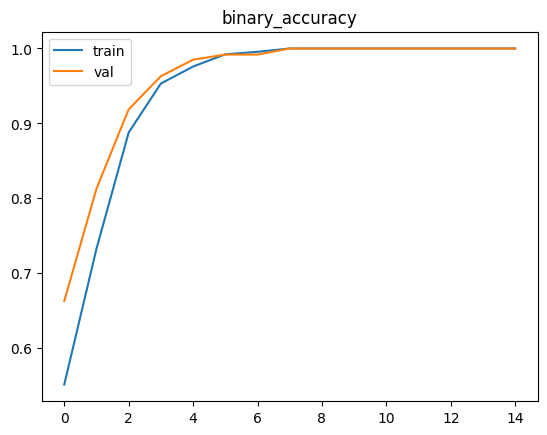

In [28]:
from deepmeg.utils.viz import plot_metrics

plot_metrics(history)
plt.show()

## Evaluate the model on train and test sets

In [29]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.16702769249677657
train_binary_accuracy: 1.0
loss: 0.16981333196163179
binary_accuracy: 1.0


## Make a prediction

#### Take a random sample from the test set

In [30]:
i = np.random.randint(len(test))
print(f'Sample {i}')
x, y = test[i]
y = y.numpy()

# unsqueezing due to the first dimension must be batch size
x = torch.unsqueeze(x, 0)

Sample 166


#### Make a prediction, print the predicted value and the actual label

In [31]:
y_pred = np.round(torch.squeeze(model(x)).detach().numpy(), 2)

print(f'Prediction: {" | ".join([str(sample).center(5, " ") for sample in y_pred])}')
print(f'Actual:     {" | ".join([str(sample).center(5, " ") for sample in y])}')

Prediction:  -2.0 |  1.74
Actual:      0.0  |  1.0 
